In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Force Function

In [ ]:
def F_kepler(u, t, mu=1.0, epsilon=1e-12):
  """
  Defines the differential equations for a simple Keplerian orbit.
  F(U,t) = [dr/dt, dv/dt] = [v, a]
  U = [x, y, vx, vy]
  F = [vx, vy, ax, ay]

  Epsilon is a softening factor to prevent division by zero.
  """
  x, y, vx, vy = u
  # Add epsilon^2 inside the square root for softening
  r_squared = x**2 + y**2 + epsilon**2
  r = np.sqrt(r_squared)
  r3 = r**3

  ax = -mu * x / r3
  ay = -mu * y / r3
  return np.array([vx, vy, ax, ay])

def jacobian_keplerian(u, t, mu=1.0, epsilon=1e-12):
    """
    The jacobian of F_kepler, with softening.
    """
    x, y, vx, vy = u
    r_squared = x**2 + y**2 + epsilon**2
    r = np.sqrt(r_squared)

    r3 = r**3
    r5 = r**5

    # Partial derivatives of acceleration
    dfdx = -mu * (1/r3 - 3*x**2 / r5)
    dfdy = -mu * (-3*x*y / r5)
    dgdxy = dfdy
    dgdy = -mu * (1/r3 - 3*y**2 / r5)

    J = np.zeros((4, 4))
    J[0, 2] = 1.0  # dx/dvx
    J[1, 3] = 1.0  # dy/dvy
    J[2, 0] = dfdx
    J[2, 1] = dfdy
    J[3, 0] = dgdxy
    J[3, 1] = dgdy
    return J

# Euler Function

In [ ]:
def euler_step(u, t, f, dt):
  """
  Performs one step of the Euler method.
  F(U,t) should be the input argument.
  """
  return u + dt * f(u, t)

# Crank_Nicolson

In [ ]:
def crank_nicolson_step(u, t, f, dt, jacobian_f=None, tol=1e-10, max_iter=20):
    """
    Performs one step of the Crank-Nicolson method using Newton-Raphson.
    F(U,t) and its jacobian_f should be input arguments.
    """
    f_current = f(u, t)

    # Use Explicit Euler for the initial guess
    u_guess = u + dt * f_current

    for _ in range(max_iter):
        # We want to find the root of:
        # G(u_next) = u_next - u - 0.5*dt * (f_current + f(u_next, t+dt))
        f_next_guess = f(u_guess, t + dt)
        G = u_guess - u - 0.5 * dt * (f_current + f_next_guess)

        if np.linalg.norm(G) < tol:
            return u_guess # Converged

        # Jacobian of G: J_G = I - 0.5*dt * J_f(u_next, t+dt)
        J_f_next = jacobian_f(u_guess, t + dt)
        J_G = np.eye(len(u)) - 0.5 * dt * J_f_next

        try:
            delta = np.linalg.solve(J_G, -G)
        except np.linalg.LinAlgError:
            print("Warning: Crank-Nicolson Jacobian is singular. Using last guess.")
            return u_guess

        u_guess = u_guess + delta

    print("Warning: Crank-Nicolson did not converge. Using last guess.")
    return u_guess

#Runge-Kutta Fourth-Order Function

In [ ]:
def rk4_step(u, t, f, dt):
  """
  Performs one step of the RK4 method.
  F(U,t) should be the input argument.
  """
  k1 = dt * f(u, t)
  k2 = dt * f(u + 0.5 * k1, t + 0.5 * dt)
  k3 = dt * f(u + 0.5 * k2, t + 0.5 * dt)
  k4 = dt * f(u + k3, t + dt)
  return u + (k1 + 2*k2 + 2*k3 + k4) / 6

# Inverse Euler

In [ ]:
def inverse_euler_step(u, t, f, dt, jacobian_f=None, tol=1e-10, max_iter=20):
    """
    Performs one step of the Inverse Euler method using Newton-Raphson.
    F(U,t) should be the input argument.
    """
    # Use Explicit Euler for the initial guess
    u_guess = u + dt * f(u, t)

    for _ in range(max_iter):
        # We want to find the root of G(u_next) = u_next - u - dt*f(u_next, t+dt)
        f_val = f(u_guess, t + dt)
        G = u_guess - u - dt * f_val

        if np.linalg.norm(G) < tol:
            return u_guess # Converged

        # J_G = I - dt * J_f
        J_f = jacobian_f(u_guess, t + dt)
        J_G = np.eye(len(u)) - dt * J_f

        try:
            delta = np.linalg.solve(J_G, -G)
        except np.linalg.LinAlgError:
            print("Warning: Newton-Raphson Jacobian is singular. Using last guess.")
            return u_guess

        u_guess = u_guess + delta

    print("Warning: Newton-Raphson did not converge. Using last guess.")
    return u_guess

# General Integration Function for a Cauchy Problem

In [ ]:
def integrate(temporal_scheme, u0, t0, tf, f, dt, **kwargs):
  """
  Integrates a Cauchy problem using a given temporal integration scheme.

  Args:
    temporal_scheme: The one-step function (e.g., euler_step, rk4_step).
    u0: Initial condition.
    t0: Initial time.
    tf: Final time.
    f: The function F(U, t) of the Cauchy problem.
    dt: The time step.
    **kwargs: Additional arguments for the scheme (e.g., jacobian_f).

  Returns:
    A (N_steps, N_vars) NumPy array of the trajectory.
  """

  # Create time array
  times = np.arange(t0, tf + dt, dt)
  N_steps = len(times)

  # Pre-allocate solution array
  trajectory = np.zeros((N_steps, len(u0)))
  trajectory[0] = u0

  u = u0
  for i in range(N_steps - 1):
    t = times[i]
    # Pass the extra arguments (like the jacobian) to the scheme
    u = temporal_scheme(u, t, f, dt, **kwargs)
    trajectory[i+1] = u

  return trajectory, times

# Plotting

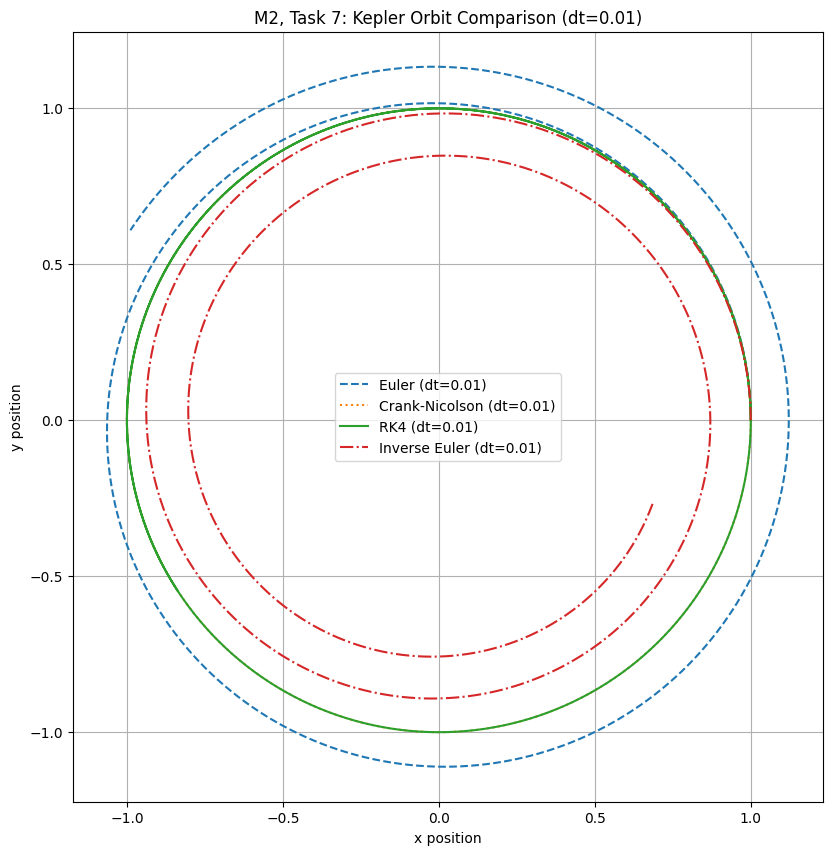

In [ ]:

# --- Setup ---
u0 = np.array([1.0, 0.0, 0.0, 1.0])  # x, y, vx, vy
t0 = 0.0
tf = 10.0
dt = 0.01

# Arguments to pass to the implicit solvers
solver_args = {'jacobian_f': jacobian_keplerian}

# --- Run Integrations ---
traj_euler, t_euler = integrate(euler_step, u0, t0, tf, F_kepler, dt)
traj_rk4, t_rk4 = integrate(rk4_step, u0, t0, tf, F_kepler, dt)

# Pass the extra arguments to the implicit schemes
traj_cn, t_cn = integrate(crank_nicolson_step, u0, t0, tf, F_kepler, dt, **solver_args)
traj_inv_euler, t_inv = integrate(inverse_euler_step, u0, t0, tf, F_kepler, dt, **solver_args)

# --- Plot Results ---
plt.figure(figsize=(10, 10))
plt.plot(traj_euler[:, 0], traj_euler[:, 1], label=f'Euler (dt={dt})', linestyle='--')
plt.plot(traj_cn[:, 0], traj_cn[:, 1], label=f'Crank-Nicolson (dt={dt})', linestyle=':')
plt.plot(traj_rk4[:, 0], traj_rk4[:, 1], label=f'RK4 (dt={dt})', linestyle='-')
plt.plot(traj_inv_euler[:, 0], traj_inv_euler[:, 1], label=f'Inverse Euler (dt={dt})', linestyle='-.')

plt.title(f'M2, Task 7: Kepler Orbit Comparison (dt={dt})')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend()
plt.grid(True)
plt.show()

# Discussion of Results
Euler (Blue, dashed): This method is unstable. With each step, it adds a bit of extra energy, causing the orbit to spiral outward.

Inverse Euler (Red, dash-dot): This method is stable but dissipative. It loses a bit of energy with each step, causing the orbit to spiral inward.

Crank-Nicolson (Orange, dotted): This method is stable and accurate. It does a good job of conserving the orbit's energy, so it follows the correct circular path without spiraling.

RK4 (Green, solid): This is a high-order, accurate method. Like Crank-Nicolson, it is very stable and produces a perfect circular orbit.

Conclusion (Task 2.8): This plot clearly shows the functionality of each integrator. Euler is unstable, Inverse Euler is stable but loses energy, and both RK4 and Crank-Nicolson are stable and accurate. This also proves that the time step (dt) is critical. That is to say that a dt that is too large can cause even accurate solvers to fail.